In [103]:
import urllib  # Импортировали библиотеку для работы с адресами и запросами Internet.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, roc_curve, make_scorer, precision_recall_curve, auc, average_precision_score

import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt import space_eval

import lightgbm as lgb
import xgboost as xgb

In [104]:
%matplotlib inline
pd.options.display.max_columns = None

In [74]:
#метрика для несбалансированных класов
def pr_auc_score(y_true, y_score):
    #Generates the Area Under the Curve for precision and recall.
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    return 'pr_auc', auc(recall, precision, reorder=True)

def pr_auc_score_xgb(preds, train_data):
    #Generates the Area Under the Curve for precision and recall.
    labels = train_data.get_label()
    y_true = np.ravel(labels)
    y_score = np.ravel(preds)
    return 'pr_auc', average_precision_score(y_true, y_score)

def pr_auc_score_lgb(preds, train_data):
    #Generates the Area Under the Curve for precision and recall.
    labels = train_data.get_label()
    y_true = np.ravel(labels)
    y_score = np.ravel(preds)
    return 'pr_auc', average_precision_score(y_true, y_score), True

# функция для балансировки классов
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label==1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

In [119]:
data = pd.read_csv('EURUSD.csv', header=None)
data.columns=['date', 'time', 'open', 'max', 'min', 'close', 'vol']

# вычисляем данные 
data['mean_o'] = (data['open'] + data['close'])/2
data['mean_m'] = (data['max'] + data['min'])/2

data['delta_oc'] = (data['open']  - data['close'])
data['delta_mm'] = (data['max']   - data['min'])
data['delta_mo'] = (data['max']   - data['open'])
data['delta_cm'] = (data['close'] - data['min'])

data['delta0_oc'] = (data['open']  - data['close'])/data['mean_m']
data['delta0_mm'] = (data['max']   - data['min']  )/data['mean_m']
data['delta0_mo'] = (data['max']   - data['open'])/data['mean_m']
data['delta0_cm'] = (data['close'] - data['min'] )/data['mean_m']

# вычисляем разницу
data['diff1'] = data['mean_m'].diff(1)
data['diff2'] = data['mean_m'].diff(2)
data['diff3'] = data['mean_m'].diff(3)
data['diff4'] = data['mean_m'].diff(4)
data['diff5'] = data['mean_m'].diff(5)

data['diff1'] =  data['diff1'].shift(-5)
data['diff2'] =  data['diff2'].shift(-5)
data['diff3'] =  data['diff3'].shift(-5)
data['diff4'] =  data['diff4'].shift(-5)
data['diff5'] =  data['diff5'].shift(-5)

# конструируем индекс 
data['datetime'] = data['date'] + ' ' + data['time']
data['datetime'] = pd.to_datetime(data['datetime'])
data.index = data['datetime']
data.drop(['date', 'time', 'datetime'], axis=1, inplace=True)
#data.dropna(inplace=True)

data.head(20)


,open,max,min,close,vol,mean_o,mean_m,delta_oc,delta_mm,delta_mo,delta_cm,delta0_oc,delta0_mm,delta0_mo,delta0_cm,diff1,diff2,diff3,diff4,diff5
datetime,,,,,,,,,,,,,,,,,,,,
2017-08-02 13:34:00,1.1823,1.1826,1.1822,1.1826,14,1.18245,1.18240,-0.0003,0.0004,0.0003,0.0004,-0.000254,0.000338,0.000254,0.000338,-0.00005,0.00005,0.00020,0.00015,0.00035
2017-08-02 13:35:00,1.1827,1.1827,1.1825,1.1826,20,1.18265,1.18260,0.0001,0.0002,0.0000,0.0001,0.000085,0.000169,0.000000,0.000085,0.00000,-0.00005,0.00005,0.00020,0.00015
2017-08-02 13:36:00,1.1825,1.1827,1.1824,1.1827,21,1.18260,1.18255,-0.0002,0.0003,0.0002,0.0003,-0.000169,0.000254,0.000169,0.000254,0.00015,0.00015,0.00010,0.00020,0.00035
2017-08-02 13:37:00,1.1826,1.1828,1.1826,1.1828,13,1.18270,1.18270,-0.0002,0.0002,0.0002,0.0002,-0.000169,0.000169,0.000169,0.000169,0.00025,0.00040,0.00040,0.00035,0.00045
2017-08-02 13:38:00,1.1827,1.1829,1.1827,1.1827,15,1.18270,1.18280,0.0000,0.0002,0.0002,0.0000,0.000000,0.000169,0.000169,0.000000,0.00000,0.00025,0.00040,0.00040,0.00035
2017-08-02 13:39:00,1.1828,1.1828,1.1827,1.1827,6,1.18275,1.18275,0.0001,0.0001,0.0000,0.0000,0.000085,0.000085,0.000000,0.000000,-0.00020,-0.00020,0.00005,0.00020,0.00020
2017-08-02 13:40:00,1.1828,1.1828,1.1827,1.1828,3,1.18280,1.18275,0.0000,0.0001,0.0000,0.0001,0.000000,0.000085,0.000000,0.000085,0.00015,-0.00005,-0.00005,0.00020,0.00035
2017-08-02 13:41:00,1.1827,1.1831,1.1827,1.1831,11,1.18290,1.18290,-0.0004,0.0004,0.0004,0.0004,-0.000338,0.000338,0.000338,0.000338,0.00010,0.00025,0.00005,0.00005,0.00030
2017-08-02 13:42:00,1.1832,1.1832,1.1831,1.1832,9,1.18320,1.18315,0.0000,0.0001,0.0000,0.0001,0.000000,0.000085,0.000000,0.000085,-0.00015,-0.00005,0.00010,-0.00010,-0.00010


In [120]:
data['grow'] = data.apply(lambda x: 1 if (x['diff1']>0 and x['diff2']>0 and x['diff3']>0 and x['diff4']>0 and x['diff5']>0) else 0, axis=1)
data['fall'] = data.apply(lambda x: 1 if (x['diff1']<0 and x['diff2']<0 and x['diff3']<0 and x['diff4']<0 and x['diff5']<0) else 0, axis=1)
data.drop(['diff1', 'diff2', 'diff3', 'diff4', 'diff5'], axis=1, inplace=True)
data.head(10)

,open,max,min,close,vol,mean_o,mean_m,delta_oc,delta_mm,delta_mo,delta_cm,delta0_oc,delta0_mm,delta0_mo,delta0_cm,grow,fall
datetime,,,,,,,,,,,,,,,,,
2017-08-02 13:34:00,1.1823,1.1826,1.1822,1.1826,14,1.18245,1.18240,-0.0003,0.0004,0.0003,0.0004,-0.000254,0.000338,0.000254,0.000338,0,0
2017-08-02 13:35:00,1.1827,1.1827,1.1825,1.1826,20,1.18265,1.18260,0.0001,0.0002,0.0000,0.0001,0.000085,0.000169,0.000000,0.000085,0,0
2017-08-02 13:36:00,1.1825,1.1827,1.1824,1.1827,21,1.18260,1.18255,-0.0002,0.0003,0.0002,0.0003,-0.000169,0.000254,0.000169,0.000254,1,0
2017-08-02 13:37:00,1.1826,1.1828,1.1826,1.1828,13,1.18270,1.18270,-0.0002,0.0002,0.0002,0.0002,-0.000169,0.000169,0.000169,0.000169,1,0
2017-08-02 13:38:00,1.1827,1.1829,1.1827,1.1827,15,1.18270,1.18280,0.0000,0.0002,0.0002,0.0000,0.000000,0.000169,0.000169,0.000000,0,0
2017-08-02 13:39:00,1.1828,1.1828,1.1827,1.1827,6,1.18275,1.18275,0.0001,0.0001,0.0000,0.0000,0.000085,0.000085,0.000000,0.000000,0,0
2017-08-02 13:40:00,1.1828,1.1828,1.1827,1.1828,3,1.18280,1.18275,0.0000,0.0001,0.0000,0.0001,0.000000,0.000085,0.000000,0.000085,0,0
2017-08-02 13:41:00,1.1827,1.1831,1.1827,1.1831,11,1.18290,1.18290,-0.0004,0.0004,0.0004,0.0004,-0.000338,0.000338,0.000338,0.000338,1,0
2017-08-02 13:42:00,1.1832,1.1832,1.1831,1.1832,9,1.18320,1.18315,0.0000,0.0001,0.0000,0.0001,0.000000,0.000085,0.000000,0.000085,0,0


In [121]:
print(data.shape)
print(data[data.grow == 1].shape)
print(data[data.fall == 1].shape)

(88335, 17)
(16997, 17)
(17046, 17)


In [11]:
#url = 'http://export.finam.ru/EURUSD_170912_171112.csv?market=5&em=83&code=EURUSD&apply=0&df=12&mf=8&yf=2017&from=12.09.2017&dt=12&mt=10&yt=2017&to=12.11.2017&p=2&f=EURUSD_170912_171112&e=.csv&cn=EURUSD&dtf=1&tmf=1&MSOR=1&mstime=on&mstimever=1&sep=3&sep2=1&datf=1&at=1'
#f = urllib.request.urlopen(url)   # Открыли соединение.
#data1 = f.read()   # Прочитали данные.
#f.close()          # Закрыли соединение.

b'Error'

## Построение модели grow - классификация

In [122]:
boost_round = 1500
nfolds = 5
test_size = 0.2
rand_state = 43
best_params =   {'application': 'binary'}

In [123]:
col2est1 = ['grow']
col2est2 = ['fall']

In [124]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(col2est1 + col2est2, axis=1), data[col2est1 + col2est2], 
                                                    test_size=test_size, random_state=rand_state)

In [125]:
ld_train = lgb.Dataset(X_train, np.ravel(y_train.drop(col2est2, axis=1)))
ld_test = lgb.Dataset(X_test)

In [126]:
np.random.seed(rand_state)
res = lgb.cv(best_params, ld_train, num_boost_round=boost_round, nfold=nfolds, feval=pr_auc_score_lgb, early_stopping_rounds=20, 
             show_stdv=True, callbacks=[lgb.print_evaluation(period=1, show_stdv=True)])
print (res.get("pr_auc-mean")[-1])
best_num_boost_round = len(res[list(res)[0]])
print(best_num_boost_round)

[1]	cv_agg's pr_auc: 0.202034 + 0.00284063
[2]	cv_agg's pr_auc: 0.204235 + 0.00355268
[3]	cv_agg's pr_auc: 0.205574 + 0.00308697
[4]	cv_agg's pr_auc: 0.205965 + 0.00319288
[5]	cv_agg's pr_auc: 0.206271 + 0.00327075
[6]	cv_agg's pr_auc: 0.206622 + 0.00345468
[7]	cv_agg's pr_auc: 0.206435 + 0.00316518
[8]	cv_agg's pr_auc: 0.206056 + 0.00284516
[9]	cv_agg's pr_auc: 0.206511 + 0.00293507
[10]	cv_agg's pr_auc: 0.206693 + 0.0030548
[11]	cv_agg's pr_auc: 0.206723 + 0.00305413
[12]	cv_agg's pr_auc: 0.206635 + 0.00295713
[13]	cv_agg's pr_auc: 0.206862 + 0.00358235
[14]	cv_agg's pr_auc: 0.207194 + 0.00377753
[15]	cv_agg's pr_auc: 0.207285 + 0.00394824
[16]	cv_agg's pr_auc: 0.207356 + 0.00426703
[17]	cv_agg's pr_auc: 0.207582 + 0.00432642
[18]	cv_agg's pr_auc: 0.207731 + 0.00455864
[19]	cv_agg's pr_auc: 0.208325 + 0.00506141
[20]	cv_agg's pr_auc: 0.208812 + 0.00500499
[21]	cv_agg's pr_auc: 0.209151 + 0.0048504
[22]	cv_agg's pr_auc: 0.209221 + 0.00503651
[23]	cv_agg's pr_auc: 0.209044 + 0.00483967

In [127]:
clf = lgb.train(best_params, ld_train, num_boost_round=best_num_boost_round, feval=pr_auc_score_lgb)
y_score = clf.predict(X_test)

In [128]:
y_test1 = y_test.drop(col2est2, axis=1)
pr_auc_score(y_test1, y_score)

('pr_auc', 0.21536450339053775)

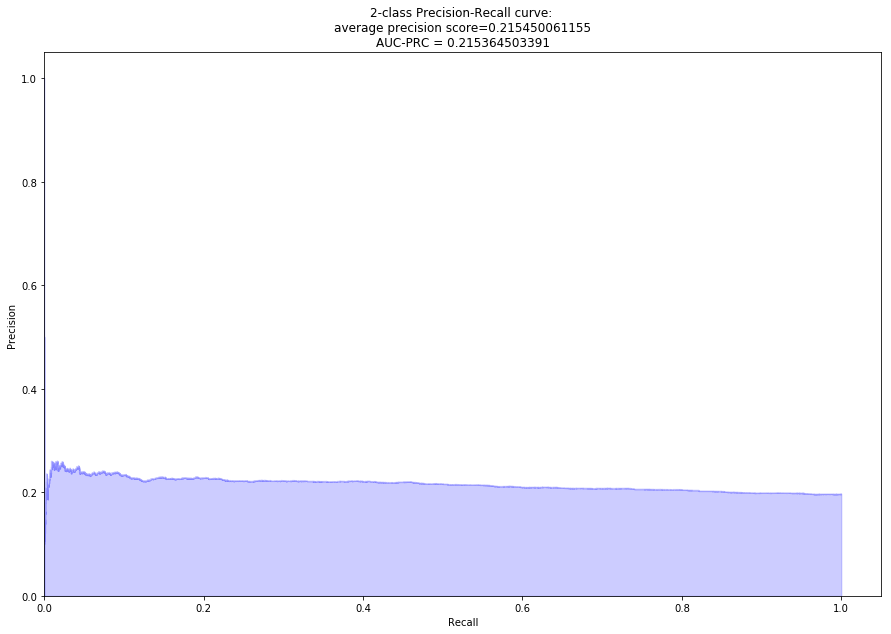

In [133]:
average_precision = average_precision_score(y_test1, y_score)

precisions, recalls, thresholds = precision_recall_curve(y_test1, y_score)
fig = plt.figure( figsize=(15, 10))
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.title('2-class Precision-Recall curve: \naverage precision score='+ str(average_precision) + 
          '\nAUC-PRC = ' + str(auc(recalls, precisions, reorder=True)))

In [134]:
results = y_test.copy()
results['Score'] = y_score
res = list()
for i in np.arange(0, len(thresholds)):
    res.append(abs((1 - precisions[i]) - (1 - recalls[i])))

In [135]:
threshold = thresholds[np.argmin(res)]
precision = precisions[np.argmin(res)]
recall = recalls[np.argmin(res)]
print('threshold ', threshold, '\nprecision ', precision, '\nrecall ', recall)

threshold  0.593573135156 
precision  0.0 
recall  0.0


In [132]:
results['grow_b'] = results['Score'].apply(lambda x: 1 if x >= threshold  else 0)
print('FP: ', results[(results.grow_b==0) & (results.grow==1)].shape[0])
print('TP: ',results[(results.grow_b==1) & (results.grow==1)].shape[0])
print('FN: ', results[(results.grow_b==1) & (results.grow==0)].shape[0])
print('TN: ',results[(results.grow_b==0) & (results.grow==0)].shape[0])
results[results.grow_b==1].sort_values('Score', ascending=False).tail(50)

FP:  3458
TP:  0
FN:  1
TN:  14208


,grow,fall,Score,grow_b
datetime,,,,
2017-09-14 12:47:00,0,0,0.593573,1


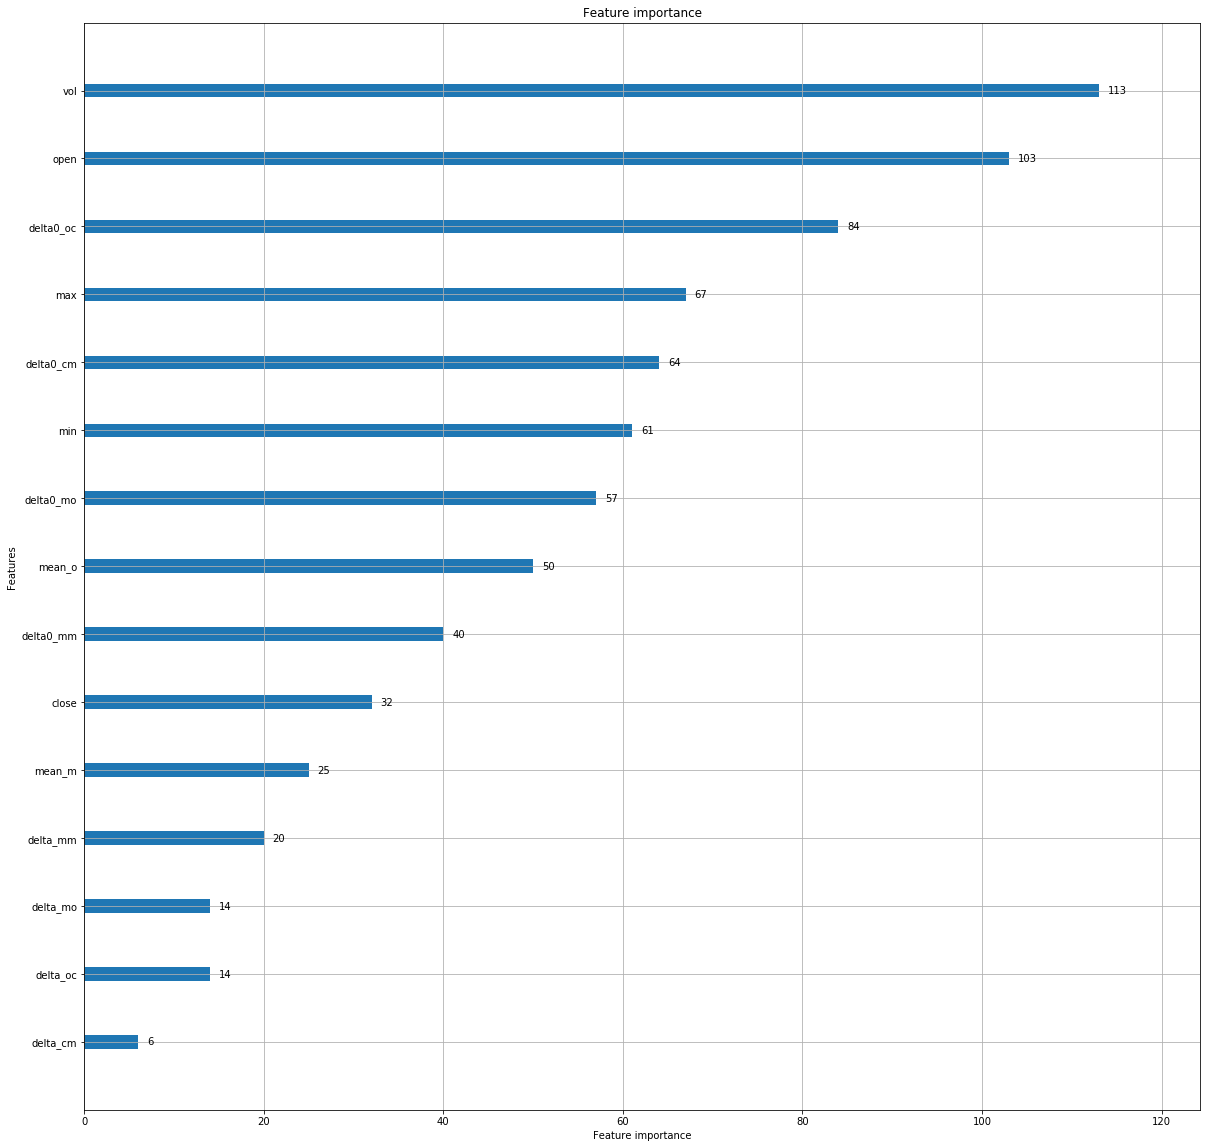

In [118]:
fig = plt.figure( figsize=(20, 20))
ax = fig.add_subplot(111)
lgb.plot_importance(clf, ax)